In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
#from datetime import datetime
from datetime import timezone
from dateutil.tz import *
import matplotlib.dates as mdates
from datetime import timedelta
#from iri2016 import timeprofile, timeprofile2
from model_utils import *


In [2]:
def Diff(li1, li2):
    return (list(list(set(li1)-set(li2)) + list(set(li2)-set(li1))))
    


In [3]:
def GetBinaryMatrix(d_prima):
    d_prima = d_prom.copy()
#d_prima[d_prima==np.nan]=0
#d_prima[d_prima!=np.nan]=1
    fils, cols = d_prima.shape
    matCount = np.zeros(d_prima.shape)
    for i in range(fils):
        for j in range(cols):
            if np.isnan(d_prima[i,j]):
                d_prima[i,j]=0
            #matCount[i,j]+=1
            else:
                d_prima[i,j]=1
                matCount[i,j]+=1
    return d_prima, matCount

In [17]:
def GetTimeRangeArrays(year, month, day, hour_i, hour_f, h_min, h_max, delta_ran):
    range_fixed = np.arange(h_min,h_max,delta_ran)
    string_t0 = '%d-%02d-%02d %02d:00:00' % (year, month, day, hour_i)
    string_tf = '%d-%02d-%02d %02d:00:00' % (year, month, day, hour_f)
    dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
    dtf = datetime.datetime.strptime(string_tf, '%Y-%m-%d %H:%M:%S')# + timedelta(days=1)
#ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
    time_range = np.arange(dt0,dtf,timedelta(seconds=120))
    #print(time_range[1]-time_range[0])
    #print("time_range.shape: ", time_range.shape)
    #print("Type: ", type(time_range[0]))
    time_range = np.array(time_range).astype(datetime.datetime)#,dtype='datetime64[s]')
    return time_range, range_fixed

In [18]:
year = 2021
month = 2
day = 2
str_month = GetMonth(month)
directory = 'Data-%s-%d/' % (str_month, year)

filename ='jul%d%02d%02d_150km.001.hdf5' % (year,month,day)#'jro20191202a.001.hdf5'#'jro20200114b.001.hdf5'#'jro20200113a.001.hdf5'
print(filename)

jul20210202_150km.001.hdf5


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:92: RuntimeWarning: Mean of empty slice
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: Mean of empty slice


TypeError: Dimensions of C (50, 360) are incompatible with X (660) and/or Y (50); see help(pcolormesh)

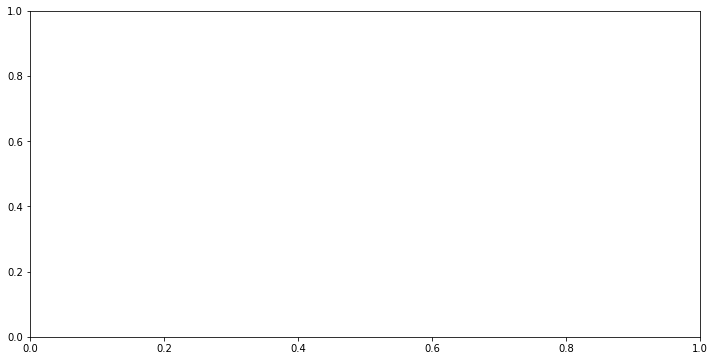

In [24]:
hour_f= 18.0
hour_i = 7.0
h_min = 120#90.0
h_max = 195#1008.75
delta_ran = 1.5
    
file_hf5 = directory + filename
hf = h5py.File(file_hf5, 'r')
rango = hf['Data/Table Layout/']['gdalt']
rango2D = hf['Data/Array Layout/2D Parameters/gdalt']
snl =  hf['Data/Table Layout/']['snl']
snl2 = hf['Data/Array Layout/2D Parameters/snl']
vipe1 = hf['Data/Array Layout/2D Parameters/vipe1'] 
vipn1 = hf['Data/Array Layout/2D Parameters/vipn1']
timestamps = hf['Data/Array Layout/']['timestamps']
time_vector = []

rango = getattr(rango, "tolist", lambda: rango)()
    ###########################################################
ran_max = max(rango)
ran_min = min(rango)
    #rang_list = list(rango)
max_index = rango.index(ran_max)
min_index = rango.index(ran_min)
rango = np.array(rango)
    
range_diff = np.diff(rango)
delta_range = range_diff[0]
    #print('delta range: ', delta_range)#valor constante para todo el arreglo
MinRange, MaxRange = np.min(rango), ran_max#120,195#90.0,1008.75 #np.min(rango), ran_max#np.max(rango)
DataMatrixRows = int((MaxRange-MinRange)/delta_range)
#range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
DataMatrix = np.ones((DataMatrixRows, snl2.shape[0]))*np.nan
RowInMatrix = np.array((rango-MinRange)/delta_range, dtype=int)
range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
prev_stamps = []
#################################
datetime_objects = []
for ts in timestamps:
    if ts in prev_stamps:
        print('Same timestap')
    else:
        date_time_obj = datetime.datetime.fromtimestamp(ts)
        datetime_objects.append(date_time_obj)
new_index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
datetime_objects = np.array(datetime_objects)#,dtype='datetime64[s]')
day = index[0].day
anio = index[0].year
month = index[0].month
mes = GetMonth(month)
time_range, range_fixed = GetTimeRangeArrays(year, month, day, hour_i, hour_f,h_min,h_max,delta_ran)

dir_plots = 'Plots-%s-%d' % (mes, anio)
col = 0 #counter for current columns
PastRow = 0 #saving past row index
    #print("range(rango.size) ",range(rango.size))
for k in range(len(rango)):
    row = RowInMatrix[k] 
        # Putting snr in corresponding matrix element
    DataMatrix[row,col] = snl[k]
    if row<PastRow:
        col += 1
    PastRow = row
data = DataMatrix.T#[::-1]

    #line.split()[0]
string_t0 = '%d-%02d-%02d %02d:00:00' % (year, month, day, 7)
dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
    #dt0 = datetime_objects[0]
    #print(string_t0)
dt_indices = np.array((datetime_objects-dt0)/timedelta(seconds=120),dtype=int)

m = np.r_[True,dt_indices[:-1]!=dt_indices[1:],True]
counts = np.diff(np.flatnonzero(m))
unq = dt_indices[m[:-1]]
times_repeated=np.c_[unq,counts] 
#time_Range_index = np.linspace(0,78,77)
time_range_index = np.arange(0,360)
print(time_range_index)

    ###############################################################################
    #d_prom = np.zeros((times_repeated.shape[0], data.shape[1]))
d_prom = np.zeros((times_repeated.shape[0], range_fixed.shape[0]))
print(data.shape, datetime_objects.shape, d_prom.shape)    
print(time_range.shape, range_fixed.shape)
for j in range(data.shape[1]):
    
    for i in range(times_repeated.shape[0]):
        if i==0:
            d_prom[i,j] = np.nanmean(data[0:times_repeated[0,1],j])
        else:
            aux = np.sum(times_repeated[0:i,1])
            aux2 = times_repeated[i,1]
            d_prom[i,j] = np.nanmean(data[aux:aux+aux2,j])
    #'''
index_aux = times_repeated[:,0]
diff = Diff(time_range_index, index_aux)
diff=np.array(diff)
diff=np.sort(diff)
diff=diff.astype(np.dtype('int64'))
    #d_prom2 = np.copy(d_prom)
    #print("diff")
    #print(diff)
b3=np.ones((time_range_index.shape[0],range_fixed.shape[0]))*np.nan

for j in range(data.shape[1]):
    b_aux=d_prom[:,j]
    for i in list(diff):
        aux=b_aux[:i]
        aux2=b_aux[i:]
        aux=np.append(aux,np.nan)
        aux=np.append(aux,b_aux[i:])
        b_aux=aux
    b3[:,j]=b_aux
    
    #'''
       
    #timedelta(seconds=600)
    #print(time_range.shape, range_fixed.shape, d_prom.shape)
    #print(time_range[0],time_range[-1])
if PlotFlag:
    fig, ax = plt.subplots(figsize=(12, 6))
    clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
    #clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')

    ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
    date_format = mdates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(date_format)
    ax.set_xlabel("Hora Local (h)", fontsize=16)
    ax.set_ylabel("Rango (km)", fontsize=17)
    ax.set_ylim([120,190])
#dia = dia - 1
    fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day) 
    plt.title(fig_title, fontsize=15)
    str_date = '(%d-%02d-%02d)' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
    fig.autofmt_xdate()
    box=ax.get_position()
    cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
    cb=plt.colorbar(clrs,cax=cbarax)        
    #cb2 = fig.colorbar(im2)
    cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #print(str_date)
        #plt.show()

In [10]:
def GetArrays(directory, filename, PlotFlag):
    hour_f= 18.0
    hour_i = 7.0
    h_min = 120#90.0
    h_max = 190#1008.75
    delta_ran = 1.5
    
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    rango = hf['Data/Table Layout/']['gdalt']
    rango2D = hf['Data/Array Layout/2D Parameters/gdalt']
    snl =  hf['Data/Table Layout/']['snl']
    snl2 = hf['Data/Array Layout/2D Parameters/snl']
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe1'] 
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn1']
    timestamps = hf['Data/Array Layout/']['timestamps']
    time_vector = []

    rango = getattr(rango, "tolist", lambda: rango)()
    ###########################################################
    ran_max = max(rango)
    ran_min = min(rango)
    #rang_list = list(rango)
    max_index = rango.index(ran_max)
    min_index = rango.index(ran_min)
    rango = np.array(rango)
    
    range_diff = np.diff(rango)
    delta_range = range_diff[0]
    #print('delta range: ', delta_range)#valor constante para todo el arreglo
    MinRange, MaxRange = 120,190#90.0,1008.75 #np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
#range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    DataMatrix = np.ones((DataMatrixRows, snl2.shape[0]))*np.nan
    RowInMatrix = np.array((rango-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    prev_stamps = []
       #################################
    datetime_objects = []
    for ts in timestamps:
        if ts in prev_stamps:
            print('Same timestap')
        else:
            date_time_obj = datetime.datetime.fromtimestamp(ts)
            datetime_objects.append(date_time_obj)
    new_index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
    index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
    datetime_objects = np.array(datetime_objects)#,dtype='datetime64[s]')
    day = index[0].day
    anio = index[0].year
    month = index[0].month
    mes = GetMonth(month)
    time_range, range_fixed = GetTimeRangeArrays(year, month, day, hour_i, hour_f,h_min,h_max,delta_ran)

    dir_plots = 'Plots-%s-%d' % (mes, anio)
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    #print("range(rango.size) ",range(rango.size))
    for k in range(len(rango)):
        row = RowInMatrix[k] 
        # Putting snr in corresponding matrix element
        DataMatrix[row,col] = snl[k]
        if row<PastRow:
            col += 1
        PastRow = row
    data = DataMatrix.T#[::-1]

    #line.split()[0]
    string_t0 = '%d-%02d-%02d %02d:00:00' % (year, month, day, 18)
    dt0 = datetime.datetime.strptime(string_t0, '%Y-%m-%d %H:%M:%S')
    #dt0 = datetime_objects[0]
    #print(string_t0)
    dt_indices = np.array((datetime_objects-dt0)/timedelta(seconds=600),dtype=int)
    #print("Datetime_objs: ",datetime_objects )
    #print("dt0: ", dt0)
    #print(dt_indices)
    #print(rango2D.shape, snl2.shape, data.shape, datetime_objects.shape)
    m = np.r_[True,dt_indices[:-1]!=dt_indices[1:],True]
    counts = np.diff(np.flatnonzero(m))
    unq = dt_indices[m[:-1]]
    times_repeated=np.c_[unq,counts] 
    #time_Range_index = np.linspace(0,78,77)
    time_range_index = np.arange(0,78)
    print(time_range_index)
    
    ###############################################################################
    #d_prom = np.zeros((times_repeated.shape[0], data.shape[1]))
    d_prom = np.zeros((times_repeated.shape[0], range_fixed.shape[0]))
    for j in range(data.shape[1]):
    
        for i in range(times_repeated.shape[0]):
            if i==0:
                d_prom[i,j] = np.nanmean(data[0:times_repeated[0,1],j])
            else:
                aux = np.sum(times_repeated[0:i,1])
                aux2 = times_repeated[i,1]
                d_prom[i,j] = np.nanmean(data[aux:aux+aux2,j])
    #'''
    index_aux = times_repeated[:,0]
    diff = Diff(time_range_index, index_aux)
    diff=np.array(diff)
    diff=np.sort(diff)
    diff=diff.astype(np.dtype('int64'))
    #d_prom2 = np.copy(d_prom)
    #print("diff")
    #print(diff)
    b3=np.ones((time_range_index.shape[0],range_fixed.shape[0]))*np.nan

    for j in range(data.shape[1]):
        b_aux=d_prom[:,j]
        for i in list(diff):
            aux=b_aux[:i]
            aux2=b_aux[i:]
            aux=np.append(aux,np.nan)
            aux=np.append(aux,b_aux[i:])
            b_aux=aux
        b3[:,j]=b_aux
    
    #'''
       
    #timedelta(seconds=600)
    #print(time_range.shape, range_fixed.shape, d_prom.shape)
    #print(time_range[0],time_range[-1])
    if PlotFlag:
        fig, ax = plt.subplots(figsize=(12, 6))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')

        ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        ax.set_ylim([120,190])
#dia = dia - 1
        fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day) 
        plt.title(fig_title, fontsize=15)
        str_date = '(%d-%02d-%02d)' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)        
    #cb2 = fig.colorbar(im2)
        cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #print(str_date)
        #plt.show()
        plt.savefig('promedio-%s.png' % (str_date))

        #plt.close(fig)
        
    return time_range, range_fixed, b3,data ,snl, snl2, index, range_array, rango, dir_plots, np.array(datetime_objects)
    ################################################################################

In [11]:
#d=Diff(a,b)
PlotFlag=True
time_range, range_fixed, d_prom,data ,snl, snl2, index, range_array, rango, dir_plots, datetime_objects = GetArrays(directory, filename, PlotFlag)
fig, ax = plt.subplots(figsize=(12, 6))

clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, d_prom.T, cmap='jet')
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("Hora Local (h)", fontsize=16)
ax.set_ylabel("Rango (km)", fontsize=17)
#fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day) 
#plt.title(fig_title, fontsize=15)
#        str_date = '(%d-%02d-%02d)' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)        
    #cb2 = fig.colorbar(im2)
cb.set_label(r'$log_{10}SNR$', fontsize=17)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: Mean of empty slice


ValueError: could not broadcast input array from shape (198) into shape (78)

In [8]:
def GetMatrix(directory, filename, PlotFlag):
   
    file_hf5 = directory + filename
    hf = h5py.File(file_hf5, 'r')
    #with h5py.File(file_hf5, 'r') as f:
    #    g = f.visit(print)
 
    rango = hf['Data/Table Layout/']['gdalt']
    snl =  hf['Data/Table Layout/']['snl']
    snl2 = hf['Data/Array Layout/2D Parameters/snl']
    vipe1 = hf['Data/Array Layout/2D Parameters/vipe1'] 
    vipn1 = hf['Data/Array Layout/2D Parameters/vipn1']
    timestamps = hf['Data/Array Layout/']['timestamps']
 
    rango = getattr(rango, "tolist", lambda: rango)()
    ###########################################################
    ran_max = max(rango)
    ran_min = min(rango)
    #rang_list = list(rango)
    max_index = rango.index(ran_max)
    min_index = rango.index(ran_min)
    range_diff = np.diff(rango)
    delta_range = range_diff[0] #valor constante para todo el arreglo
    MinRange, MaxRange = np.min(rango), ran_max#np.max(rango)
    DataMatrixRows = int((MaxRange-MinRange)/delta_range)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    DataMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    RowInMatrix = np.array((rango-MinRange)/delta_range, dtype=int)
    range_array = np.linspace(MinRange, MaxRange, DataMatrixRows+1)
    RangeMatrix = np.ones((DataMatrixRows+1, snl2.shape[0]))*np.nan
    prev_stamps = []
#################################
    datetime_objects = []
    for ts in timestamps:
        if ts in prev_stamps:
            print('Same timestap')
        else:
            date_time_obj = datetime.datetime.fromtimestamp(ts)
            datetime_objects.append(date_time_obj)
    index = pd.DatetimeIndex(datetime_objects) # timedelta(hours=5)
#################################    
    string_date = index[0].strftime('%B %d, %Y, %r')
    #line.split()[0]
    mes = string_date.split()[0]
    month_prime = index[0].month
    dia = index[0].day
    anio = index[0].year
    mes = GetMonth(month_prime)
    dir_plots = 'Plots-%s-%d' % (mes, anio)
    col = 0 #counter for current columns
    PastRow = 0 #saving past row index
    #print("range(rango.size) ",range(rango.size))
    for k in range(len(rango)):
        row = RowInMatrix[k] 
    # Putting snr in corresponding matrix element
        DataMatrix[row,col] = snl[k]
        if row<PastRow:
            col += 1
        PastRow = row
    data = DataMatrix#[::-1]
 
    print("Shapes involving in the plotting: ", data.T.shape, range_array.shape, len(datetime_objects))
    print("snl2.shape: ", snl2.shape)
    #######################################################################################################
    if (PlotFlag):
        fig, ax = plt.subplots(figsize=(12, 6))
        x_min = mdates.date2num(np.min(index))
        x_max = mdates.date2num(np.max(index))
        extent=[x_min, x_max,ran_min,ran_max]
        #im2 = plt.imshow(data, cmap='jet',aspect='auto',interpolation='nearest',origin="lower", extent=extent)
        clrs= ax.pcolormesh(mdates.date2num(datetime_objects), range_array, data, cmap='jet')
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Hora Local (h)", fontsize=16)
        ax.set_ylabel("Rango (km)", fontsize=17)
        fig_title = r'F-Dispersa (%d-%02d-%02d)' % (anio, month_prime, dia) 
        plt.title(fig_title, fontsize=15)
        # This simply sets the x-axis data to diagonal so it fits better.
        fig.autofmt_xdate()
        box=ax.get_position()
        cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
        cb=plt.colorbar(clrs,cax=cbarax)        
        #cb2 = fig.colorbar(im2)
        cb.set_label(r'$log_{10}SNR$', fontsize=17)
        #plt.savefig(r'ESF-no-labels-%d-%02d-%02d.png' % (year[0], month[0], days[0]))
        plt.savefig(r'%s/ESF-prueba-escalado-%d-%02d-%02d.png' % (dir_plots,anio, month_prime, dia))
        plt.show()
        plt.close(fig)
       
    
    return  data ,snl, snl2, index, range_array, rango, dir_plots, np.array(datetime_objects)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: Mean of empty slice


(78, 245)


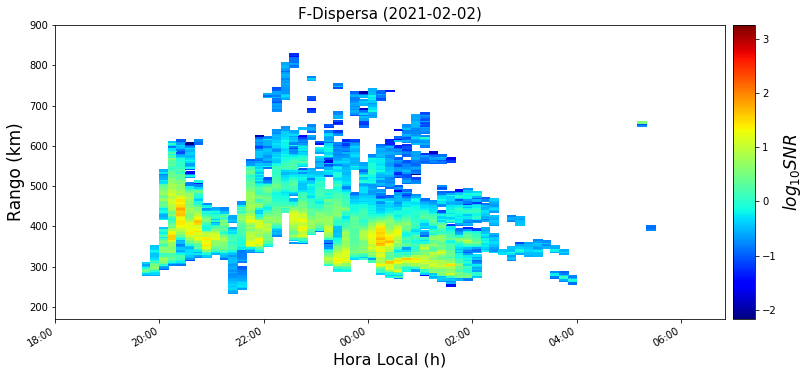

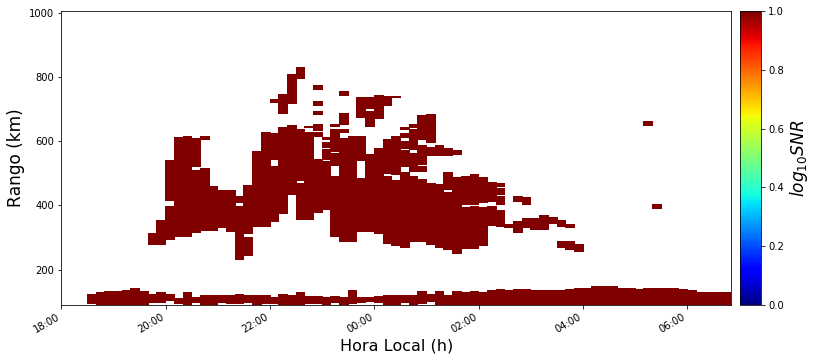

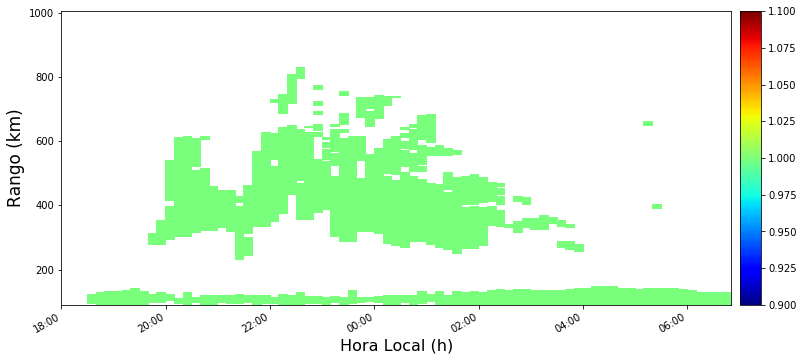

In [9]:
'''
PlotFlag = True
data ,snl,snl2,index, range_array, rango, dir_plots, datetime_objects = GetMatrix(directory, filename, PlotFlag)
print(data.shape, snl2.shape,len(snl), index.shape, range_array.shape, len(rango),np.diff(range_array)[0],len(datetime_objects))
print("datetime_objects: ", datetime_objects.shape)
'''
time_range, range_fixed, d_prom,data ,snl, snl2, index, range_array, rango, dir_plots, datetime_objects = GetArrays(directory, filename, PlotFlag)
print(d_prom.shape)
d_prima = d_prom.copy()
#d_prima[d_prima==np.nan]=0
#d_prima[d_prima!=np.nan]=1
fils, cols = d_prima.shape
matCount = np.zeros(d_prima.shape)
for i in range(fils):
    for j in range(cols):
        if np.isnan(d_prima[i,j]):
            d_prima[i,j]=0
            #matCount[i,j]+=1
        else:
            d_prima[i,j]=1
            matCount[i,j]+=1

d_prima[d_prima==0]=np.nan
matCount[matCount==0]=np.nan
fig, ax = plt.subplots(figsize=(12, 6))

clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, d_prima.T, cmap='jet')
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("Hora Local (h)", fontsize=16)
ax.set_ylabel("Rango (km)", fontsize=17)
#fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day) 
#plt.title(fig_title, fontsize=15)
#        str_date = '(%d-%02d-%02d)' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)        
    #cb2 = fig.colorbar(im2)
cb.mappable.set_clim(0,1)

cb.set_label(r'$log_{10}SNR$', fontsize=17)


fig, ax = plt.subplots(figsize=(12, 6))

clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, matCount.T, cmap='jet')
ax.xaxis_date()
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.set_xlabel("Hora Local (h)", fontsize=16)
ax.set_ylabel("Rango (km)", fontsize=17)
#fig_title = r'F-Dispersa (%d-%02d-%02d)' % (year, month, day) 
#plt.title(fig_title, fontsize=15)
#        str_date = '(%d-%02d-%02d)' % (year, month, day)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cb.mappable.set_clim(0,1)
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)        
    #cb2 = fig.colorbar(im2)
#cb.set_label(r'$log_{10}SNR$', fontsize=17)

jul20210202_esf.001.hdf5
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]


/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: Mean of empty slice
/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: Mean of empty slice


jul20210212_esf.001.hdf5
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
jul20210215_esf.001.hdf5
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
jul20210203_esf.001.hdf5
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
jul20210214_esf.001.hdf5
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 

/home/juanpablo/yes/lib/python3.7/site-packages/ipykernel_launcher.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


jul20210226_esf.001.hdf5
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
jul20210209_esf.001.hdf5
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
jul20210204_esf.001.hdf5
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]


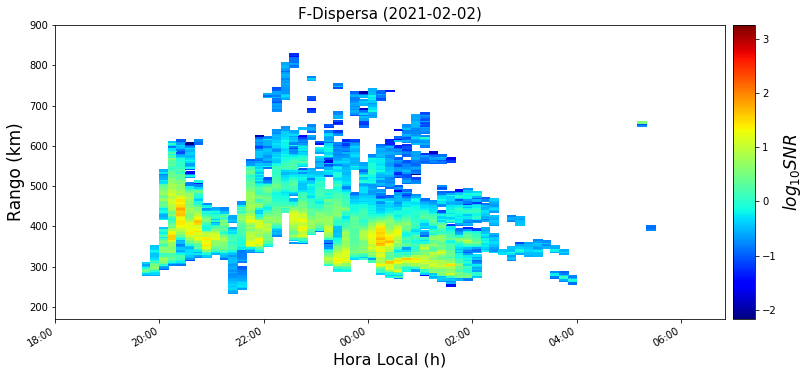

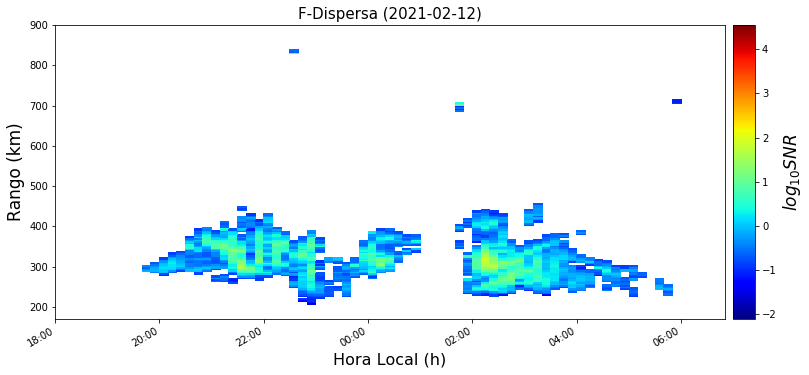

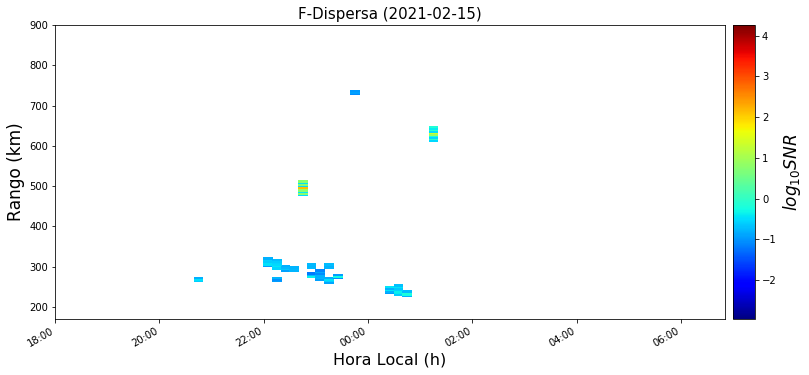

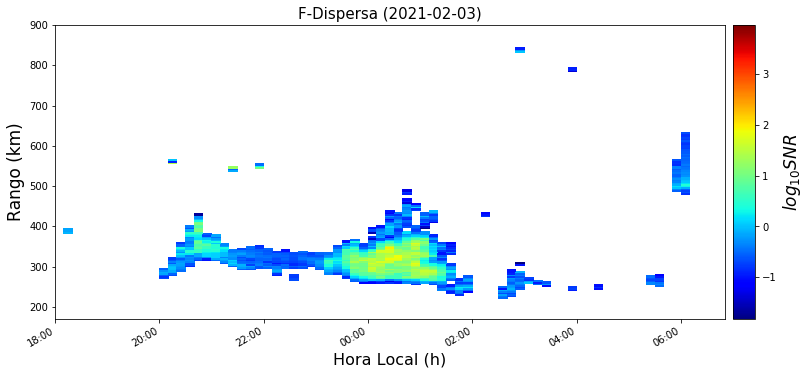

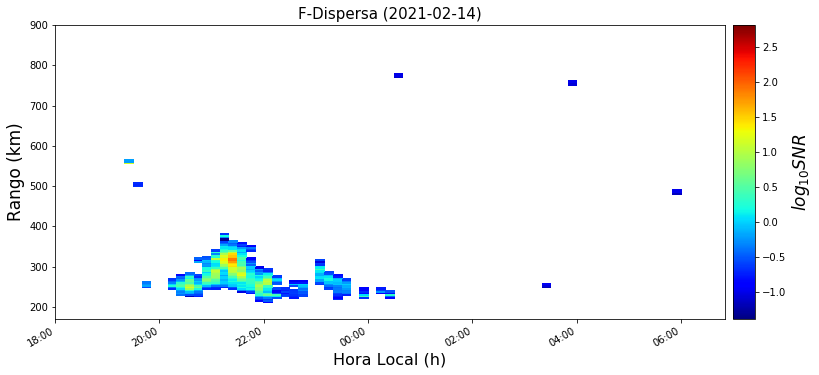

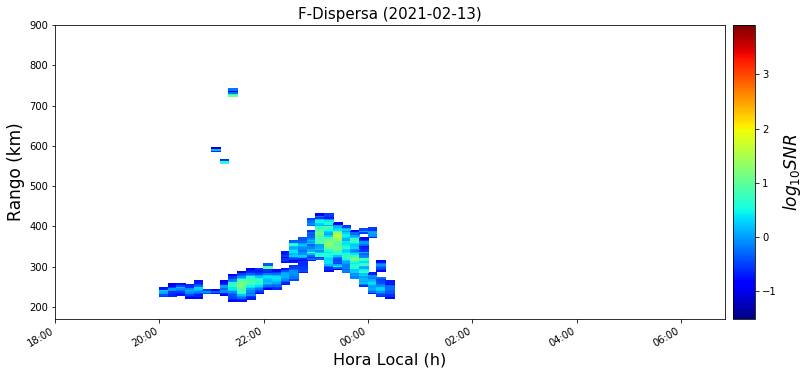

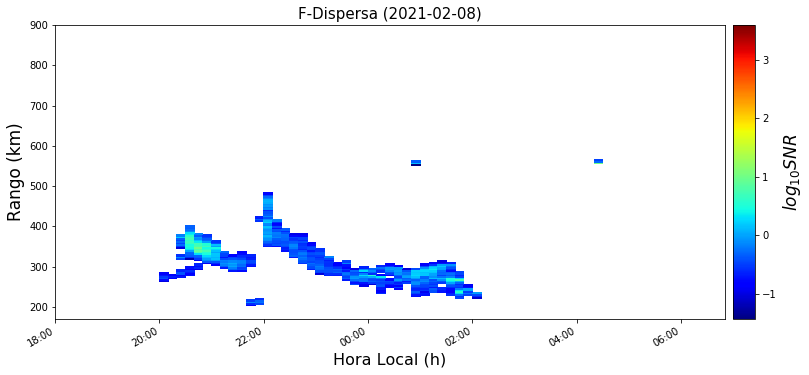

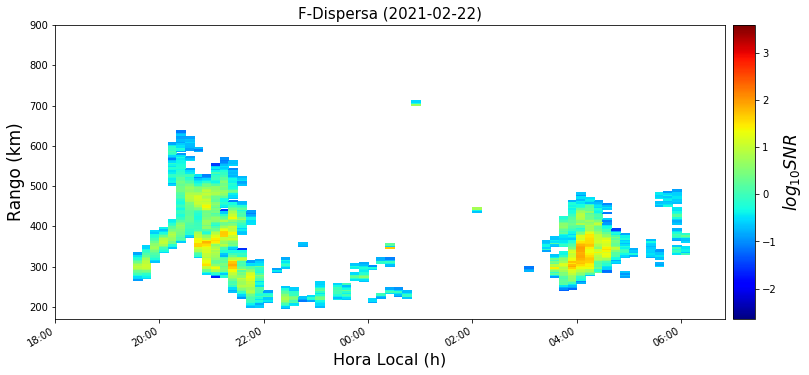

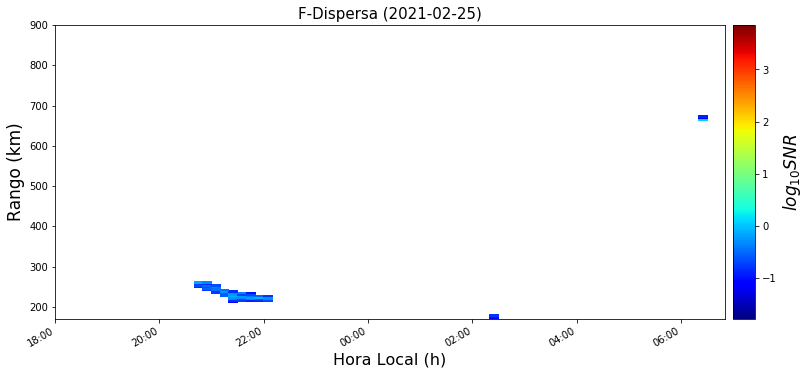

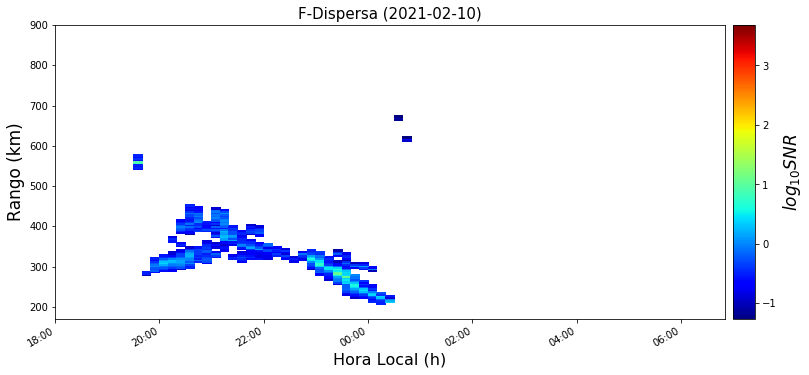

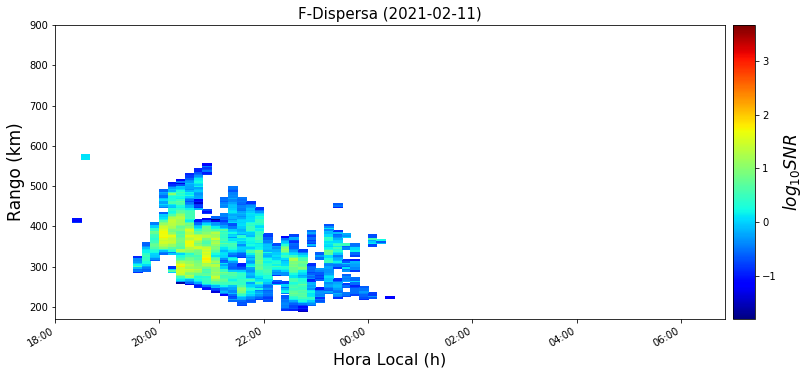

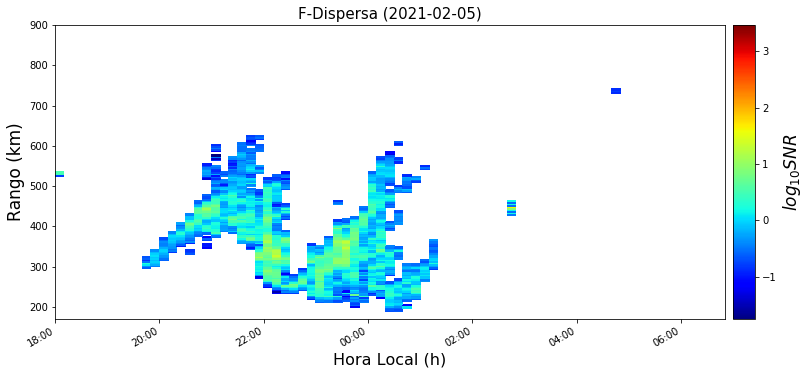

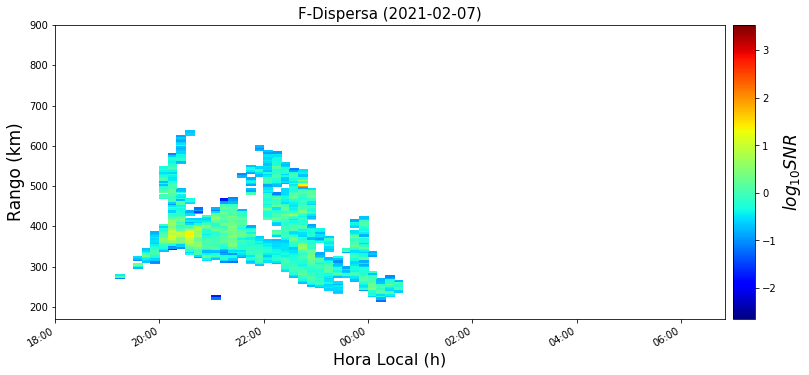

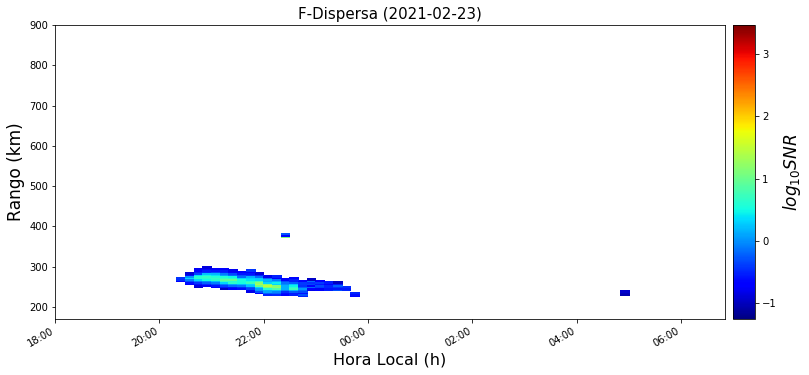

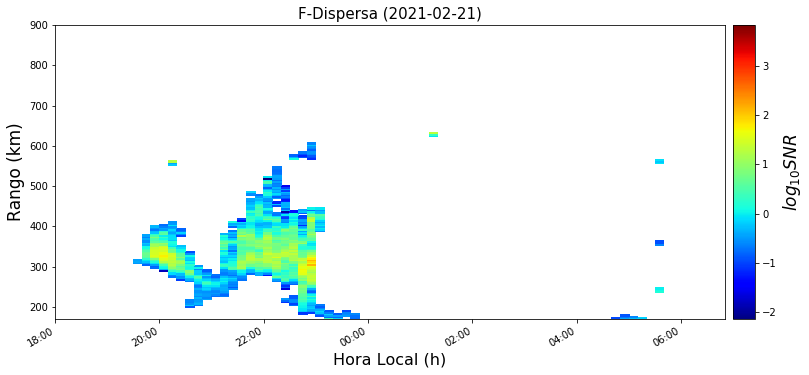

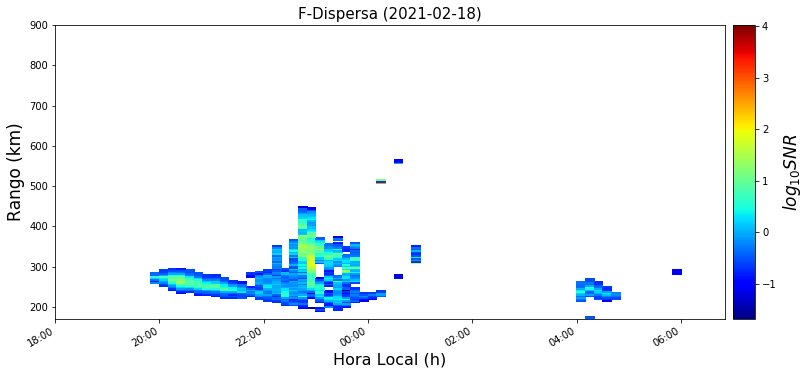

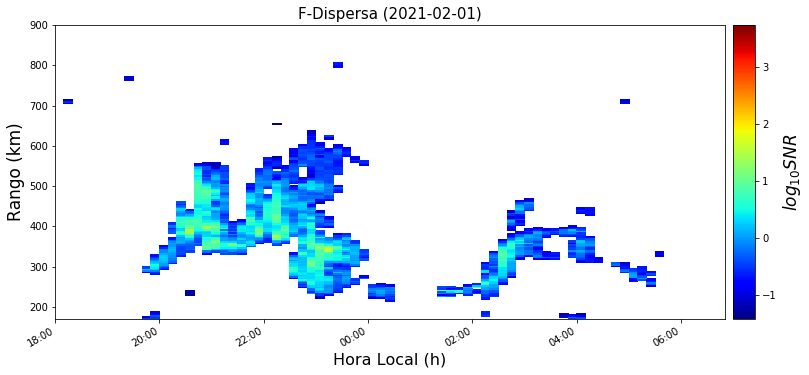

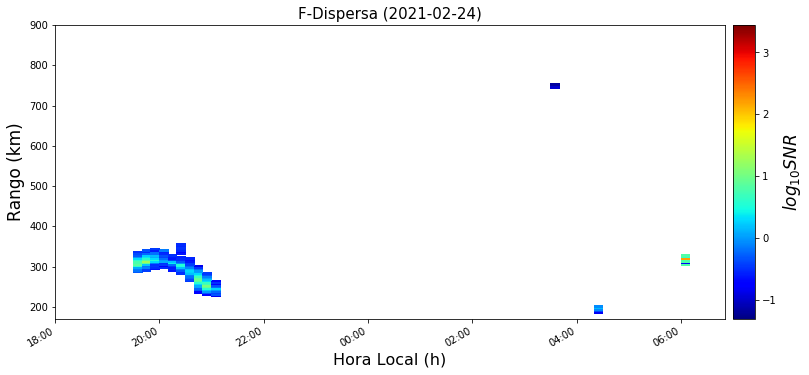

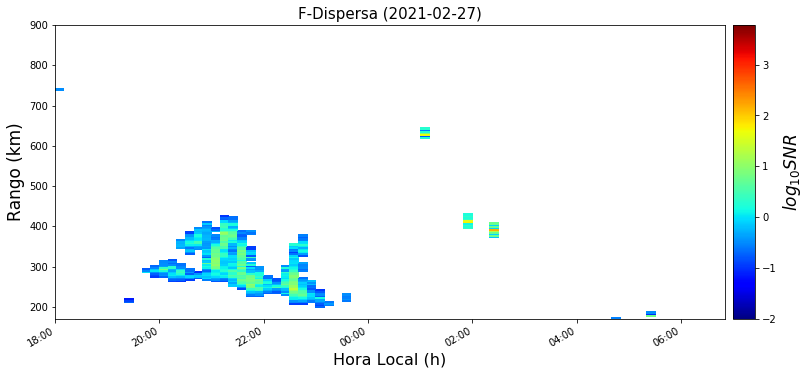

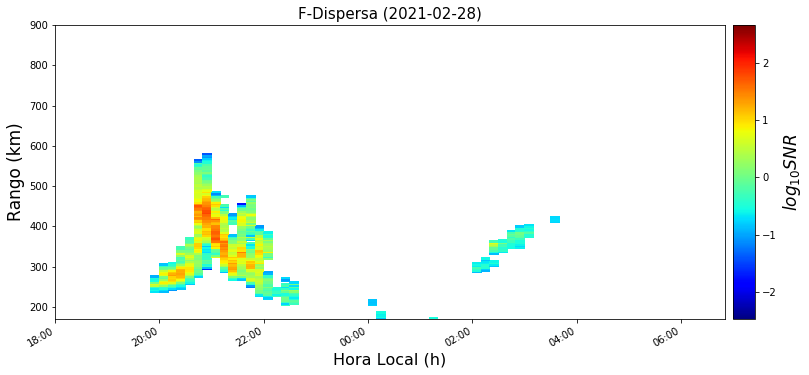

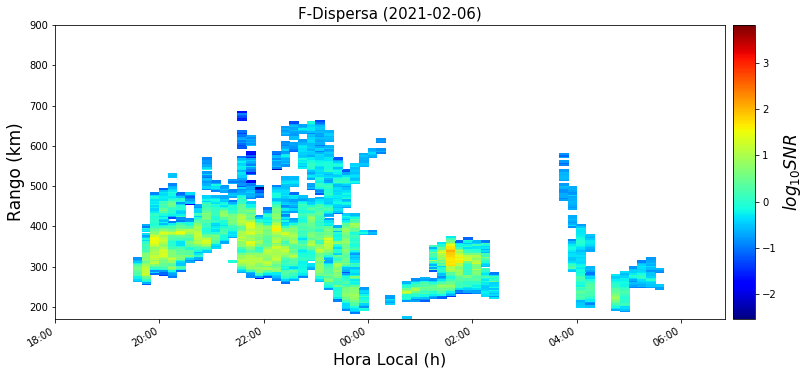

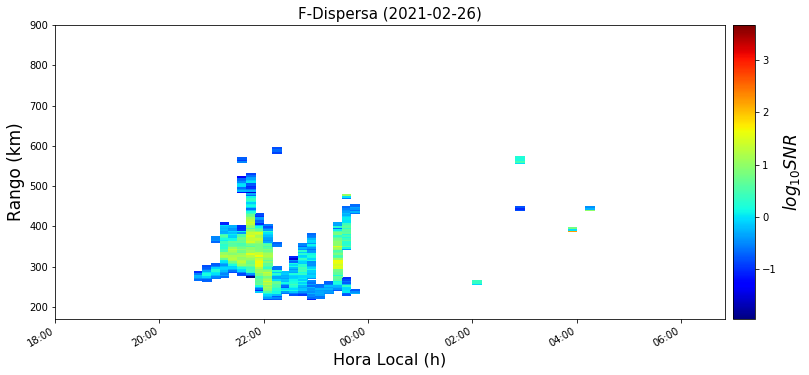

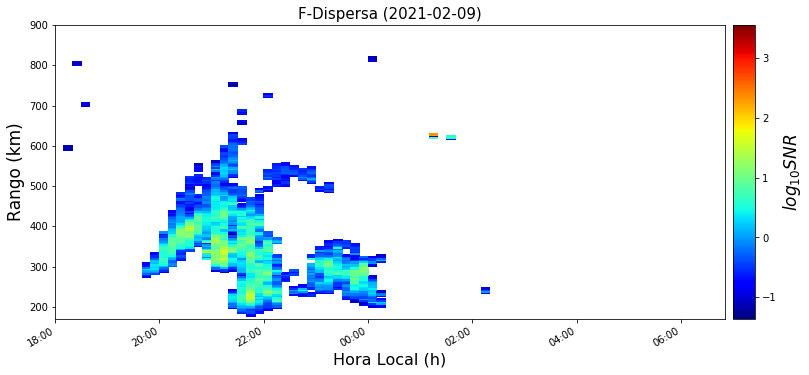

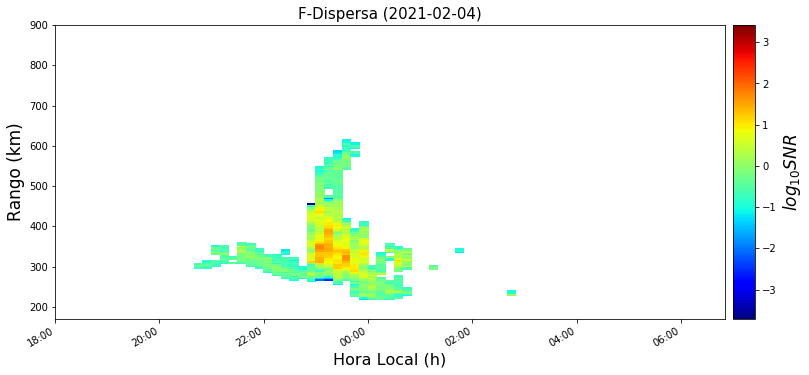

In [10]:
mat_avg = np.zeros((78, 245))
counter = 0
#counter = np.zeros((78, 245))
PlotFlag = True
plot_format= 'png'
array_list = []
for filename2 in os.listdir(directory):
    if filename2.endswith(".hdf5"):
        print('========================================================')
        print(filename2)
        #data , snl2, snl, index, range_array, rango, dir_plots, time_vector = GetMatrix(directory, filename2, PlotFlag)
        time_range, range_fixed, d_prom,data ,snl, snl2, index, range_array, rango, dir_plots, datetime_objects = GetArrays(directory, filename2, PlotFlag)
        matBin, matCount = GetBinaryMatrix(d_prom)
        #d_prima = d_prom.copy()
        #d_prima[np.isnan(d_prima)]=0
        #d_prima[~np.isnan(d_prima)]=1
        #array_list.append(d_prom)
        #mat_temp, matCounter = GetBinaryMatrix(d_prima)
        #mat_avg = mat_avg + d_prima
        mat_avg = mat_avg + matBin
        counter = counter + 1 #+ matCount
        #print(range_array[0], range_array[-1], index[0], index[-1])
        #print("datetime_objects: ", datetime_objects.shape,np.diff(datetime_objects)[0])
        #print(data.shape, len(snl), index.shape, range_array.shape, len(rango),np.diff(range_array)[0])
        #print('========================================================')
        #counter+=1

In [11]:
#mat_avg[mat_avg==0]=np.nan
mat_avg_final=100*mat_avg/counter

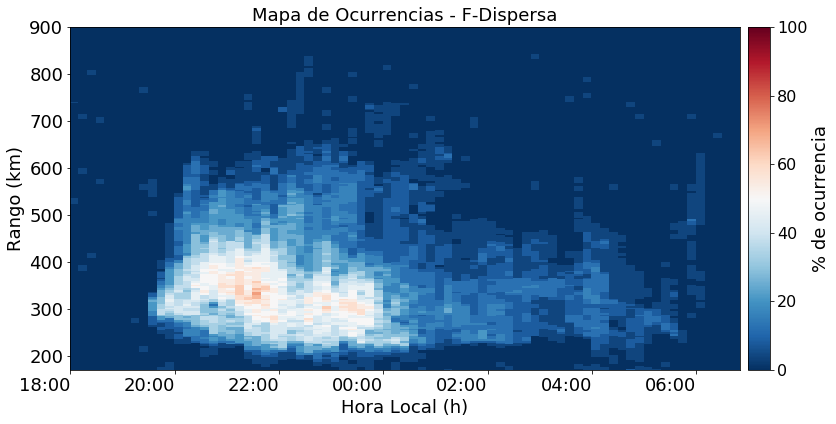

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))
#        clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, b3.T,cmap='jet')
color_palette = 'RdBu_r'#'Reds'
clrs= ax.pcolormesh(mdates.date2num(time_range), range_fixed, mat_avg_final.T,cmap=color_palette)#'RdBu_r')#'jet')

ax.xaxis_date()
    #ax.set_xlim(mdates.date2num(dt0),mdates.date2num(dtf))
date_format = mdates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_format)
ax.xaxis.set_tick_params(labelsize=18)
ax.yaxis.set_tick_params(labelsize=18)
#ax.tick_params(axis='x', rotation=0)
#ax.tick_params(axis='y', rotation=0)
ax.set_xlabel("Hora Local (h)", fontsize=18)
ax.set_ylabel("Rango (km)", fontsize=18)
ax.set_ylim([170,900])
#dia = dia - 1
#ax.xticks(fontsize=14, rotation=90)


fig_title = r'Mapa de Ocurrencias - F-Dispersa' #% (year, month, day) 
plt.title(fig_title, fontsize=18)
    # This simply sets the x-axis data to diagonal so it fits better.
fig.autofmt_xdate()
box=ax.get_position()
cbarax=fig.add_axes([box.x0+box.width+0.01, box.y0, 0.025, box.height])
cb=plt.colorbar(clrs,cax=cbarax)
cb.mappable.set_clim(0,100)
    #cb2 = fig.colorbar(im2)
cb.set_label(r'% de ocurrencia', fontsize=18)
cb.ax.tick_params(labelsize=16)
str_fig = '%d-%s-nuevo-%s' % (year, GetMonth(month),color_palette)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=0 )

plt.savefig(str_fig)